<a href="https://colab.research.google.com/github/saarangp/dreammachines/blob/main/helmholtz_datasets.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# General Helmholtz Notebook

Notebook to run helmholtz model on any dataset. 

**Note**: this should only be run in google colab! 

In [ ]:
#@markdown ## Imports and Loading Model
#@markdown We will load our Helmholtz Model from the [repo](https://github.com/saarangp/dreammachines), and import the helmholtz class as `hm`

import numpy as np
import tensorflow as tf 
import os
import tensorflow_datasets as tfds
from tqdm import tqdm
import matplotlib.pyplot as plt
import matplotlib.cm as cm
import matplotlib.animation as animation
import IPython
from IPython.display import Image



if "dreammachines" not in os.listdir():
  !git clone https://github.com/saarangp/dreammachines

!pip install tf-nightly

from dreammachines import helmholtz as hm

## Load Dataset

Now we can load a dataset of our choice from `tensorflow_datasets`. 

**Some Notes** (as of 11/24):

*   Model can only work on binary images (no colors) 



In [ ]:
data_name = 'fashion_mnist'
split = 'test' #choose the smaller split please

ds, info = tfds.load(data_name, split=split, with_info=True, try_gcs=True)

tfds.as_dataframe(ds.take(4), info)

Shuffling and writing examples to /root/tensorflow_datasets/fashion_mnist/3.0.1.incomplete0B8XW6/fashion_mnist-train.tfrecord


Shuffling and writing examples to /root/tensorflow_datasets/fashion_mnist/3.0.1.incomplete0B8XW6/fashion_mnist-test.tfrecord


Dataset fashion_mnist downloaded and prepared to /root/tensorflow_datasets/fashion_mnist/3.0.1. Subsequent calls will reuse this data.


,image,label
0,,4 (Coat)
1,,4 (Coat)
2,,9 (Ankle boot)
3,,7 (Sneaker)


In [ ]:
for e in ds.take(1):
  im_shape = (e['image'].shape[0], e['image'].shape[1])
flat_im_shape = im_shape[0]*im_shape[1]
print("Image Shape: ", im_shape)
print("Flattened Image Shape ", flat_im_shape)

Image Shape:  (28, 28)
Flattened Image Shape  784


In [ ]:
images = []
labels = []
for item in tqdm(tfds.as_numpy(ds)):
  image = item['image']
  if image.shape[2] != 1:
    image = tf.image.rgb_to_grayscale(image).numpy()
  image = image[:,:,0].reshape(flat_im_shape)
  #binarize image
  image = image > .5
  label = item['label']
  images.append(image)
  labels.append(label)

images = np.array(images)
labels = np.array(labels)
print(images.shape)

10000it [00:02, 4116.60it/s]

(10000, 784)


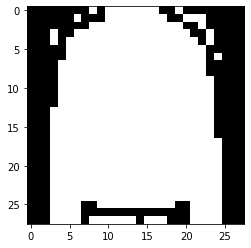

In [ ]:
plt.imshow(images[0].reshape(im_shape), cmap = 'gray')

(1000, 784)


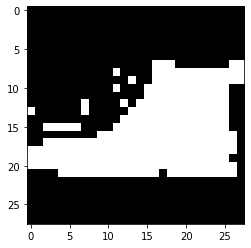

In [ ]:
#Any further filtering here (by label or whatever)
images = images[labels == 9] #None
print(images.shape)
plt.imshow(images[0].reshape(im_shape), cmap = 'gray')

## Wake - Sleep

Now that we have our dataset, we can run our helmholtz machine and see how we do! 

**Some Notes** (as of 11/24)


*   Currently the stopping parameter of KL Divergence has not been implemented, for each image, we do `1000` wake-sleep cycles. 
*   Each layer size is initialized to the size of the image
*   There are only 2 layers 
*   As mentioned above, only works on binarized images
*   Has not been optimized to run on GPU




In [ ]:
#Define our Helmholtz Model w/ size of layers and learning rate
h = hm.helmholtz(epsilon=.1, size = flat_im_shape)

In [ ]:
#Now let us train our wake sleep model!
#highly recommend connecting to a hosted runtime for this
for image in tqdm(images[::10]):
    h.train(image)

100%|██████████| 100/100 [07:29<00:00,  4.50s/it]


## Now lets explore our dreams! 

In [ ]:
dreams = h.dreams
print(len(dreams)), len(dreams[0])

100000


(None, 784)

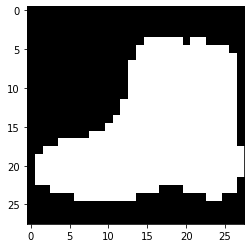

In [ ]:
plt.imshow(dreams[-1].reshape(im_shape), cmap='gray')

100%|██████████| 1000/1000 [00:00<00:00, 1126.30it/s]


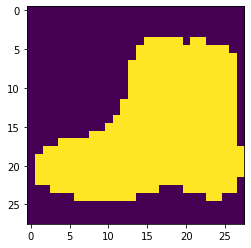

In [ ]:
frames = [] # for storing the generated images
fig = plt.figure()
for dream in tqdm(dreams[::100]):
    dream = dream.reshape(im_shape)
    frames.append([plt.imshow(dream,animated=True)])

ani = animation.ArtistAnimation(fig, frames, interval=10, blit=True)
ani.save('dreaming.gif',writer=animation.PillowWriter())

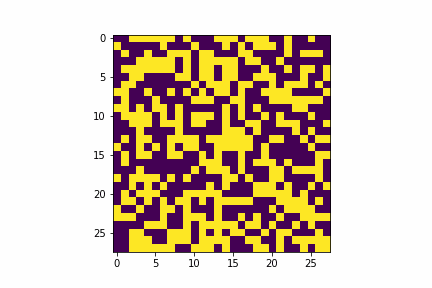

In [ ]:
Image(open('dreaming.gif','rb').read())

In [ ]:
ani.save('dreaming.mp4')